# Extract EMS Data on EMSR586: Sydney Floods

This notebook shows how to acquire and parse flood metadata, and initial floodmaps, from the Copernicus Emergency Management Service web page. At the end of the notebook we will have selected the local government areas affected by flooding.

## Background

The Copernicus EMS Activation Mappings for individual events given by unique EMSR codes may be accessed [here](https://emergency.copernicus.eu/mapping/list-of-activations-rapid). Available resources include ZIP files contain multiple products (e.g., shapefiles) for an event. 

The EMSR586 event covers flooding in NSW during early July 2022.
https://emergency.copernicus.eu/mapping/list-of-components/EMSR586

In [1]:
# Necessary Python modules
import sys
import os
os.environ['USE_PYGEOS'] = '0'
import glob
from tqdm import tqdm
import numpy as np
from datetime import datetime
from pathlib import Path
import matplotlib.pyplot as plt
from datetime import timedelta
import geopandas as gpd
import pandas as pd
from shapely.geometry import mapping
from shapely.geometry import box
import ee
#import geemap.folium as geemap
import geemap.foliumap as geemap
import folium

import warnings
warnings.filterwarnings('ignore', '', RuntimeWarning)

from dotenv import load_dotenv

from ml4floods.data import ee_download, create_gt, utils
from ml4floods.data.copernicusEMS import activations

## Load environment and project details

As with the other notebooks, we load credentials and project details from a hidden ```.env``` file.

In [2]:
# Load environment variables (including path to credentials) from '.env' file
env_file_path = "../.env"

assert load_dotenv(dotenv_path=env_file_path) == True, "[ERR] failed to load environment!"
assert "GOOGLE_APPLICATION_CREDENTIALS" in os.environ, "[ERR] missing $GOOGLE_APPLICATION_CREDENTIAL!"
assert "GS_USER_PROJECT" in os.environ, "[ERR] missing $GS_USER_PROJECT!"
key_file_path = os.environ["GOOGLE_APPLICATION_CREDENTIALS"]
assert os.path.exists(key_file_path), f"[ERR] Google credential key file does not exist: \n{key_file_path} "
assert "ML4FLOODS_BASE_DIR" in os.environ, "[ERR] missing $ML4FLOODS_BASE_DIR!"
base_path = os.environ["ML4FLOODS_BASE_DIR"]
assert os.path.exists(base_path), f"[ERR] base path does not exist: \n{base_path} "
print("[INFO] Successfully loaded FloodMapper environment.")

[INFO] Successfully loaded FloodMapper environment.


**Set the details of the event and mapping session here.**

In [4]:
# Official EMSR Code on Copernicus website
emsr_code = "EMSR586"

# Flooding date range (UTC)
# May need to start day or two earlier
flood_start_date = "2022-07-01"
flood_end_date = "2022-07-24"

## Download EMS Rapid Activation Data

First let's take a look at the recent Copernicus activations using the ML4Floods 'activations' module, which provides methods to query the EMS, download event data and parse information within.

In [5]:
# Fetch a table of activations events after a specified date
table_activations_ems = activations.table_floods_ems(event_start_date=flood_start_date)
table_activations_ems

Title    CodeDate   Type  \
Code                                                                    
EMSR650                        Flood in Mozambique  2023-02-09  Flood   
EMSR649                     Flood in Sicily, Italy  2023-02-09  Flood   
EMSR646                            Flood in Kosovo  2023-01-19  Flood   
EMSR645       Tropical Storm Cheneso in Madagascar  2023-01-19  Storm   
EMSR644    Ice Jam and Flood in Aizkraukles and...  2023-01-10  Flood   
EMSR642             Storm in Emilia Romagna, Italy  2022-11-22  Storm   
EMSR640          Flood in Scotland, United Kingdom  2022-11-18  Flood   
EMSR639                            Flood in Belize  2022-11-02  Flood   
EMSR637                        Floods in Australia  2022-10-12  Flood   
EMSR636                Typhoon Noru in Philippines  2022-09-25  Storm   
EMSR635                  Hurricane Fiona in Canada  2022-09-24  Storm   
EMSR634  Flood in Marche and Umbria Regions, Italy  2022-09-15  Flood   
EMSR631                          Flood in Pakistan  2022-09-10  Flood   
EMSR629                         Floods in Pakistan  2022-08-25  Flood   
EMSR586        Flood in New South Wales, Australia  2022-07-03  Flood   

                Country  
Code                     
EMSR650      Mozambique  
EMSR649           Italy  
EMSR646             NaN  
EMSR645      Madagascar  
EMSR644          Latvia  
EMSR642           Italy  
EMSR640  United Kingdom  
EMSR639          Belize  
EMSR637       Australia  
EMSR636     Philippines  
EMSR635          Canada  
EMSR634           Italy  
EMSR631        Pakistan  
EMSR629        Pakistan  
EMSR586       Australia

We can see that information on EMSR587 is available, starting on 2022-07-03. Next we retrieve the URLs pointing to the activation products in ZIP files.

In [6]:
# Retreive the URLs of available ZIP files for EMSR586
zip_files_activation_url_list = activations.fetch_zip_file_urls(emsr_code)
print("There are {:d} ZIP files available.".format(len(zip_files_activation_url_list)))
zip_files_activation_url_list.sort()
zip_files_activation_url_list

There are 36 ZIP files available.


['https://emergency.copernicus.eu/mapping/download/195070/EMSR586_AOI01_DEL_PRODUCT_r1_VECTORS_v1_vector.zip',
 'https://emergency.copernicus.eu/mapping/download/195079/EMSR586_AOI03_DEL_PRODUCT_r1_VECTORS_v1_vector.zip',
 'https://emergency.copernicus.eu/mapping/download/195090/EMSR586_AOI02_DEL_PRODUCT_r1_VECTORS_v1_vector.zip',
 'https://emergency.copernicus.eu/mapping/download/195151/EMSR586_AOI02_DEL_MONIT01_r1_RTP02_v1_vector.zip',
 'https://emergency.copernicus.eu/mapping/download/195152/EMSR586_AOI02_DEL_MONIT01_r1_VECTORS_v1_vector.zip',
 'https://emergency.copernicus.eu/mapping/download/195173/EMSR586_AOI03_DEL_MONIT01_r1_RTP02_v1_vector.zip',
 'https://emergency.copernicus.eu/mapping/download/195174/EMSR586_AOI03_DEL_MONIT01_r1_VECTORS_v1_vector.zip',
 'https://emergency.copernicus.eu/mapping/download/195184/EMSR586_AOI02_DEL_MONIT02_r1_RTP02_v1_vector.zip',
 'https://emergency.copernicus.eu/mapping/download/195185/EMSR586_AOI02_DEL_MONIT02_r1_VECTORS_v1_vector.zip',
 'https

In [7]:
# Specify the local folder to save into and create if necessary.
# By convention, we use the folder "<base_path>/flood-activations/<emsr_code>".
folder_out = os.path.join(base_path, "flood-activations", emsr_code, "ems_products")
print("[INFO] Local output folder:\n", folder_out)
os.makedirs(folder_out, exist_ok=True)

[INFO] Local output folder:
 /Users/cpurcell/Documents/PROJECT_FLOODS/ML4Floods_DEVELOPMENT/ML4Floods_Enhanced/FloodMapper/flood-activations/EMSR586/ems_products


Now download the files (if necessary) and unzip into folders.

In [8]:
# Loop through the available files, download if necessary, and unzip
zip_files_activations = []
unzip_files_activations = []
print("[INFO] downloading {:d} files".format(len(zip_files_activation_url_list)))
for url_str in tqdm(zip_files_activation_url_list):
    zip_file_name = os.path.split(url_str)[-1]
    local_zip_file = os.path.join(folder_out, zip_file_name)
    if not os.path.exists(local_zip_file):
        # Perform the download
        local_zip_file = activations.download_vector_cems(url_str, folder_out=folder_out)
    zip_files_activations.append(local_zip_file)
print("[INFO] unzipping {:d} files".format(len(zip_files_activation_url_list)))
for local_zip_file in tqdm(zip_files_activations):
    unzipped_file = activations.unzip_copernicus_ems(local_zip_file, folder_out=folder_out)
    unzip_files_activations.append(unzipped_file)
    

[INFO] downloading 36 files


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 5371.77it/s]


[INFO] unzipping 36 files


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 928.72it/s]


In [9]:
# Check that the files have been downloaded and unzipped
cmd = f"tree -L 1 {folder_out}"
!{cmd}

/Users/cpurcell/Documents/PROJECT_FLOODS/ML4Floods_DEVELOPMENT/ML4Floods_Enhanced/FloodMapper/flood-activations/EMSR586/ems_products
├── EMSR586_AOI01_DEL_MONIT01_r1_RTP02_v2_vector
├── EMSR586_AOI01_DEL_MONIT01_r1_RTP02_v2_vector.zip
├── EMSR586_AOI01_DEL_MONIT01_r1_VECTORS_v2_vector
├── EMSR586_AOI01_DEL_MONIT01_r1_VECTORS_v2_vector.zip
├── EMSR586_AOI01_DEL_MONIT02_r1_RTP02_v2_vector
├── EMSR586_AOI01_DEL_MONIT02_r1_RTP02_v2_vector.zip
├── EMSR586_AOI01_DEL_MONIT02_r1_VECTORS_v2_vector
├── EMSR586_AOI01_DEL_MONIT02_r1_VECTORS_v2_vector.zip
├── EMSR586_AOI01_DEL_PRODUCT_r1_VECTORS_v1_vector
├── EMSR586_AOI01_DEL_PRODUCT_r1_VECTORS_v1_vector.zip
├── EMSR586_AOI02_DEL_MONIT01_r1_RTP02_v1_vector
├── EMSR586_AOI02_DEL_MONIT01_r1_RTP02_v1_vector.zip
├── EMSR586_AOI02_DEL_MONIT01_r1_VECTORS_v1_vector
├── EMSR586_AOI02_DEL_MONIT01_r1_VECTORS_v1_vector.zip
├── EMSR586_AOI02_DEL_MONIT02_r1_RTP02_v1_vector
├── EMSR586_AOI02_DEL_MONIT02_r1_RTP02_v1_vector.zip
├── EMSR586_AOI02_DEL_MONIT02_r1_VE

Each folder contains shapefiles with useful information on:

* facilitiesL = linear features (power lines)
* facilitiesA = facilities (parks, golf courses, plants)
* builtUpA = build up areas (urban areas)
* transportationL = transportations lines (e.g., roads and tracks)
* transportationA = transportation areas (e.g., airports)
* physiographyL = physiography lines (e.g., height contours)
* naturalLandUseA = land use areas
* imageFootprintA = source image footprint

However, the information we care about is in these files:

* observedEventA = observed event areas (polygons)
* hydrographyL = linear water bodies (permanent streams)
* hydrographyA = wide water bodies (permanent lakes, rivers)
* areaOfInterest = polygon around AoI

## Building EMSR Flood Metadata and Floodmaps


The function `filter_register_copernicusems` firsts checks that all the shapefiles follow the expected conventions with respect to timestamp and data availability. It then extracts 1) the AoI polygons, 2) hydrography information, 3) event information and 4) metadata into a separate dictionary for each ZIP file. 

The function `generate_floodmap` creates a geoDataFrame for each ZIP file containing the EMS-derived hydrography and flooding masks.

All of this information is appended to an in-memory list variable called `registers`.

In [10]:
# Extract the event start date from the table
code_date = table_activations_ems.loc[emsr_code]["CodeDate"]

# Loop through the unzipped folders and extract the metadata and water masks into memory
registers = []
for unzip_folder in unzip_files_activations:
    folder = os.path.split(unzip_folder)[-1]
    
    # Extract 1) AOI, 2) hydrography, 3) observed event into a dict
    metadata_floodmap = activations.filter_register_copernicusems(unzip_folder, code_date)
    
    # Create a 'floodmap' hydrography dataframe and save to list of dictionaries called 'registers'
    if metadata_floodmap is not None:    
        floodmap = activations.generate_floodmap(metadata_floodmap, folder_files=unzip_folder)
        registers.append({"metadata_floodmap": metadata_floodmap, "floodmap": floodmap})
        print(f"Folder {folder} processed correctly.")
    else:
        print(f"Folder {folder} does not follow the expected format. It won't be processed")

Folder EMSR586_AOI01_DEL_PRODUCT_r1_VECTORS_v1_vector processed correctly.
Folder EMSR586_AOI03_DEL_PRODUCT_r1_VECTORS_v1_vector processed correctly.
Folder EMSR586_AOI02_DEL_PRODUCT_r1_VECTORS_v1_vector processed correctly.
Folder EMSR586_AOI02_DEL_MONIT01_r1_RTP02_v1_vector processed correctly.
Folder EMSR586_AOI02_DEL_MONIT01_r1_VECTORS_v1_vector processed correctly.
Folder EMSR586_AOI03_DEL_MONIT01_r1_RTP02_v1_vector processed correctly.
Folder EMSR586_AOI03_DEL_MONIT01_r1_VECTORS_v1_vector processed correctly.
Folder EMSR586_AOI02_DEL_MONIT02_r1_RTP02_v1_vector processed correctly.
Folder EMSR586_AOI02_DEL_MONIT02_r1_VECTORS_v1_vector processed correctly.
Folder EMSR586_AOI04_DEL_PRODUCT_r1_VECTORS_v1_vector processed correctly.
Folder EMSR586_AOI01_DEL_MONIT01_r1_RTP02_v2_vector processed correctly.
Folder EMSR586_AOI01_DEL_MONIT01_r1_VECTORS_v2_vector processed correctly.
Folder EMSR586_AOI04_DEL_PRODUCT_r1_RTP02_v1_vector processed correctly.
Folder EMSR586_AOI05_DEL_PRODUCT_r1

In [11]:
# Sanity check
print("[INFO] There are {:d} registers available.".format(len(registers)))

[INFO] There are 36 registers available.


## Visualise the hydrology information from the first ZIP file

In [12]:
# Examine the metadata associated with the first ZIP file
idx = 0
metadata = registers[idx]['metadata_floodmap']
metadata

{'event id': 'EMSR586_AOI01_DEL_PRODUCT',
 'layer name': 'EMSR586_AOI01_DEL_PRODUCT_observedEventA_r1_v1',
 'event type': 'Riverine flood',
 'satellite date': Timestamp('2022-07-04 08:28:00+0000', tz='UTC'),
 'country': 'NaN',
 'satellite': 'TERRASAR-X',
 'bounding box': {'west': 150.62700550400007,
  'east': 150.76010716300004,
  'north': -33.85398572499997,
  'south': -34.12598159299995},
 'reference system': 'epsg:4326',
 'abstract': 'NaN',
 'purpose': 'NaN',
 'source': 'CopernicusEMS',
 'area_of_interest_polygon': <POLYGON ((150.813 -34.134, 150.563 -34.137, 150.564 -33.85, 150.815 -33.85,...>,
 'observed_event_file': 'EMSR586_AOI01_DEL_PRODUCT_observedEventA_r1_v1.shp',
 'area_of_interest_file': 'EMSR586_AOI01_DEL_PRODUCT_areaOfInterestA_r1_v1.shp',
 'ems_code': 'EMSR586',
 'aoi_code': 'AOI01',
 'date_ems_code': datetime.datetime(2022, 7, 3, 0, 0, tzinfo=datetime.timezone.utc),
 'satellite_pre_event': 'Open Street Map',
 'timestamp_pre_event': Timestamp('2022-07-03 00:00:00+0000',

In [13]:
# Examine the hydrology information associated with the first file
floodmap = registers[idx]['floodmap']
floodmap

geometry           w_class  \
0     POLYGON ((150.63308 -33.88629, 150.63307 -33.8...      Flooded area   
1     POLYGON ((150.63259 -33.89104, 150.63258 -33.8...      Flooded area   
2     POLYGON ((150.63973 -33.90725, 150.63972 -33.9...      Flooded area   
3     POLYGON ((150.75993 -33.91262, 150.75993 -33.9...      Flooded area   
4     POLYGON ((150.64120 -33.91189, 150.64123 -33.9...      Flooded area   
...                                                 ...               ...   
2184  LINESTRING (150.77962 -34.01528, 150.77931 -34...      BH141-Stream   
2185  LINESTRING (150.76866 -34.08693, 150.76847 -34...      BH141-Stream   
2186  LINESTRING (150.78640 -34.03136, 150.78745 -34...      BH141-Stream   
2187  LINESTRING (150.78069 -34.04184, 150.78640 -34...      BH141-Stream   
2188  POLYGON ((150.81250 -34.13394, 150.56348 -34.1...  area_of_interest   

                source  
0                flood  
1                flood  
2                flood  
3                flood  
4                flood  
...                ...  
2184           hydro_l  
2185           hydro_l  
2186           hydro_l  
2187           hydro_l  
2188  area_of_interest  

[2189 rows x 3 columns]

In [14]:
# Check the unique classes of data in the floodmap table
np.unique(floodmap.source)

array(['area_of_interest', 'flood', 'hydro', 'hydro_l'], dtype=object)

These classes are:
 * area_of_interest = bounds of the area
 * flood = bounds of the flooded areas
 * hydro = lakes and rivers
 * hydro_l = linear water courses (negligible width)

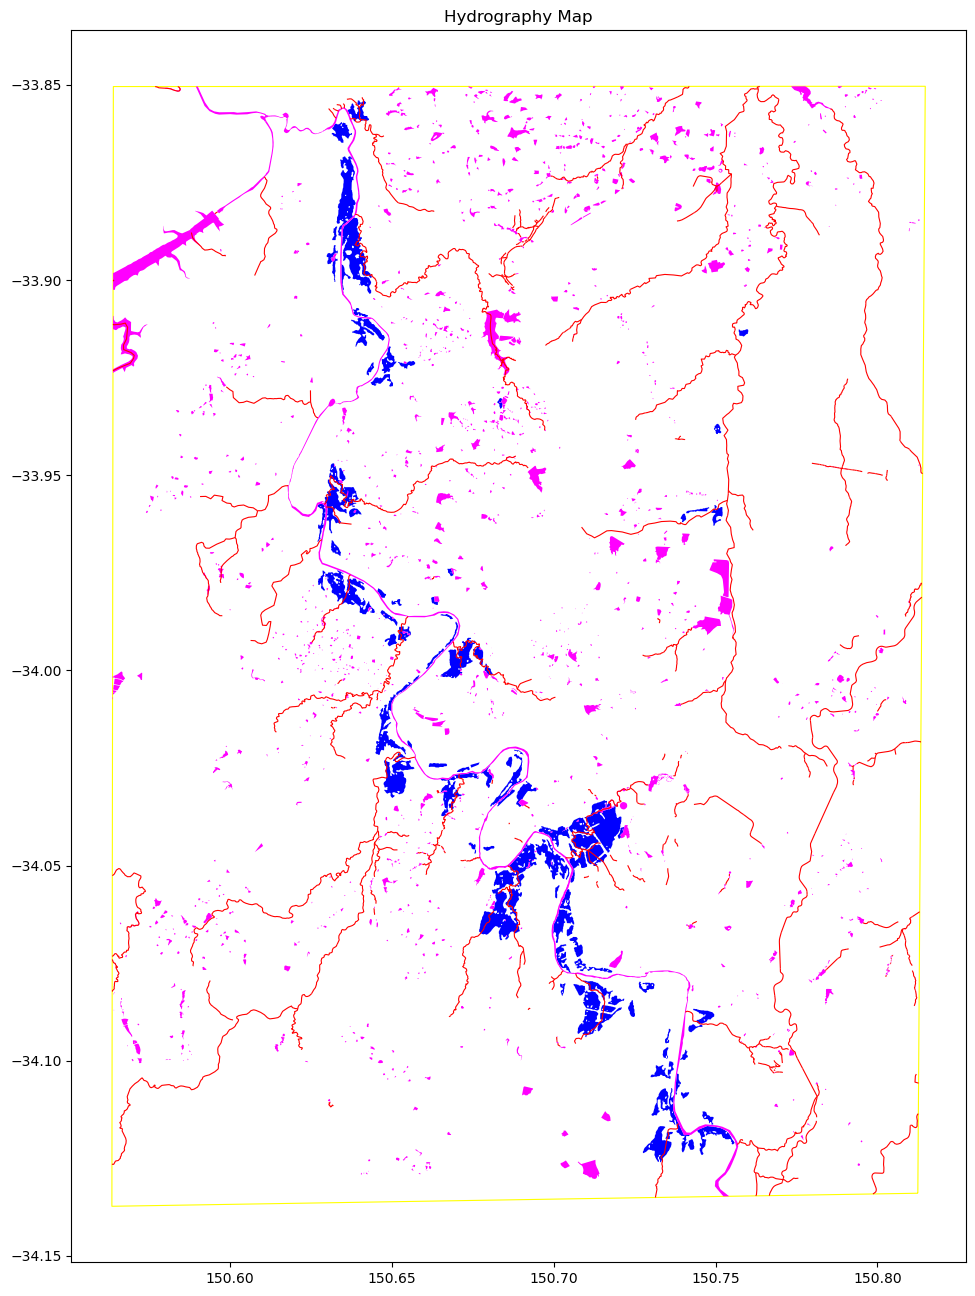

In [15]:
# Plot the flood
fig, ax = plt.subplots(figsize=(16,16))
floodmap[floodmap["source"] == "area_of_interest"].plot(ax=ax, facecolor="None", edgecolor="yellow",
                                               label="AOI", linewidth=0.8)
floodmap[floodmap["source"] == "flood"].plot(ax=ax, facecolor="blue", edgecolor="None", 
                                             label="Flood Maps", linewidth=0.8)
floodmap[floodmap["source"] == "hydro_l"].plot(ax=ax, facecolor="None", edgecolor="red", 
                                               label="Hydrography Line", linewidth=0.8)
floodmap[floodmap["source"] == "hydro"].plot(ax=ax, facecolor="magenta", edgecolor="None",
                                               label="Hydrography Area", linewidth=0.8)
ax.set(title="Hydrography Map")
plt.show()

## Merge the hydrology from all ZIP files and visualise

First merge the AoI and hydrology information into single dataframes.

In [16]:
aoi_list = []
floodmap_list = []
for register in registers:
    # Build a list of AoI polygons
    aoi_list.append(register["metadata_floodmap"]["area_of_interest_polygon"])
    # Build a list of water polygons
    floodmap_list.append(register["floodmap"])

# Create a geodataframe of the AoIs and the external boundary
crs_str = register["metadata_floodmap"]["reference system"]
aoi_df = gpd.GeoDataFrame(geometry=aoi_list, crs=crs_str)
aoi_df["AOI_Index"] = aoi_df.index
aoi_ext_poly = box(*aoi_df.total_bounds)
aoi_ext_df = gpd.GeoDataFrame(geometry=[aoi_ext_poly], crs=crs_str)

# Create a dataframe of the water components
floodmap_all = pd.concat(floodmap_list)

Then plot all information on a common map (may take 30 - 60 seconds).

You probably don't want to do this for larger areas than shown here due to processing limits.

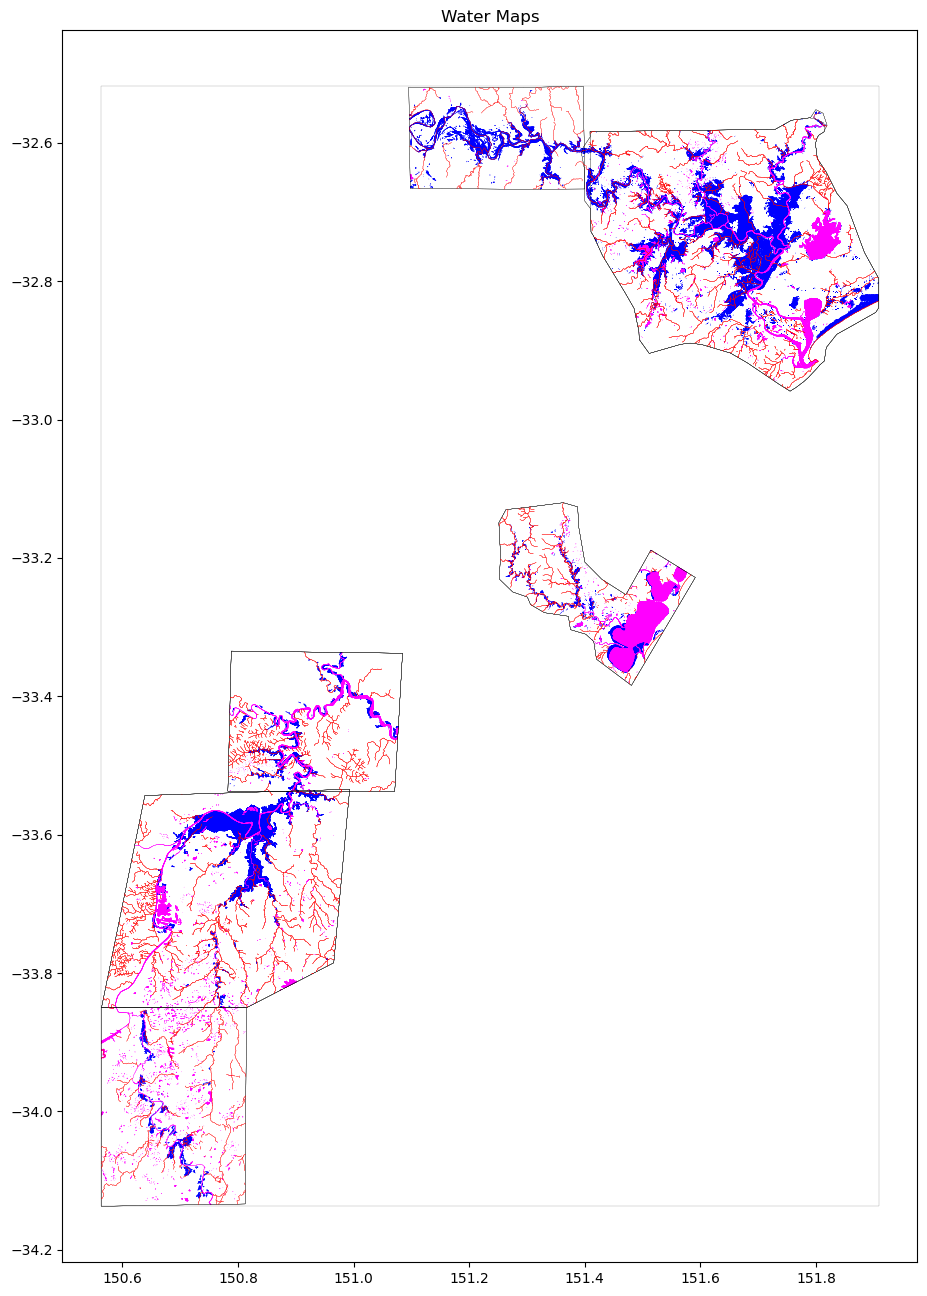

In [17]:
# Plot the information in the EMSR ZIP files
fig, ax = plt.subplots(figsize=(16,16))
floodmap_all[floodmap_all["source"] == "flood"].plot(ax=ax, facecolor="blue", edgecolor="None", 
                                             label="Flood Maps", linewidth=0.1)
floodmap_all[floodmap_all["source"] == "hydro_l"].plot(ax=ax, facecolor="None", edgecolor="red", 
                                               label="Hydrography Line", linewidth=0.1)
floodmap_all[floodmap_all["source"] == "hydro"].plot(ax=ax, facecolor="magenta", edgecolor="None",
                                               label="Hydrography Area", linewidth=0.1)
aoi_df.plot(ax=ax, facecolor="None", edgecolor="black", 
                                               label="AoI", linewidth=0.1)
aoi_ext_df.plot(ax=ax, facecolor="None", edgecolor="black", 
                                               label="AoI External", linewidth=0.1)
ax.set(title="Water Maps")
plt.show()

## Determine which LGAs are affected by flooding

<AxesSubplot: >

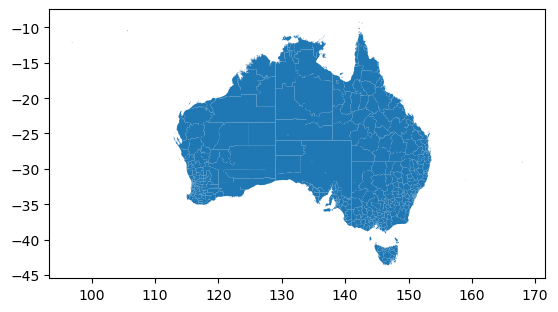

In [18]:
# Load the LGAs from the local shapefile
# We could also perform a query on the database
lga_file_path = os.path.join(base_path, "resources/LGAs/LGA_2022_AUST_GDA2020.shp")
lga_gdf = gpd.read_file(lga_file_path).to_crs(crs_str)
lga_gdf.dropna(inplace=True)
lga_gdf.plot()

In [19]:
# Get the unique names of the intersecting LGAs
lga_list = lga_gdf.overlay(aoi_df, how = 'intersection')["LGA_NAME22"].to_list()
lga_list = list(set(lga_list))

# Filter the LGA dataframe for the affected LGA names
lga_affected_df = lga_gdf[lga_gdf["LGA_NAME22"].isin(lga_list)]

print(f"The {len(lga_list)} affected LGAs are:\n", lga_list)

The 21 affected LGAs are:
 ['Campbelltown (NSW)', 'Wollondilly', 'Maitland', 'Penrith', 'Fairfield', 'Newcastle', 'Cumberland', 'Camden', 'Hawkesbury', 'Dungog', 'Parramatta', 'Liverpool', 'Lake Macquarie', 'Cessnock', 'Hornsby', 'The Hills', 'Central Coast (NSW)', 'Blue Mountains', 'Port Stephens', 'Blacktown', 'Singleton']


In [20]:
# And visualise the affected LGAs
m = lga_affected_df.explore(style_kwds={"fillOpacity": 0.0}, name="Affected LGAs")
aoi_df.explore(m=m, style_kwds={"fillOpacity": 0.1}, color="red", name="AoIs")
folium.LayerControl(collapsed=False).add_to(m)
m

Note that the list of LGA names can be supplied as an argument to the Floodmapper data download script ```01_download_images.py```. We can format that list using a simple Python statement.

In [21]:
# Print a comma-separated list of LGA names
",".join(lga_list)

'Campbelltown (NSW),Wollondilly,Maitland,Penrith,Fairfield,Newcastle,Cumberland,Camden,Hawkesbury,Dungog,Parramatta,Liverpool,Lake Macquarie,Cessnock,Hornsby,The Hills,Central Coast (NSW),Blue Mountains,Port Stephens,Blacktown,Singleton'

## Choose the area to map

From a visual inspection of the map, we choose to map the LGAs intersected by AoIs 30 and 35, covering flooding on the Hunter river. These are: 

```
['Newcastle', 'Port Stephens', 'Maitland', 'Singleton', 'Cessnock']
```

We will select these geometries and save to the local disk as a GeoJSON file for use with NEMA Floodmapper. Of course, we could also simply use all of the LGAs in ```lga_afffected_df```.

<AxesSubplot: >

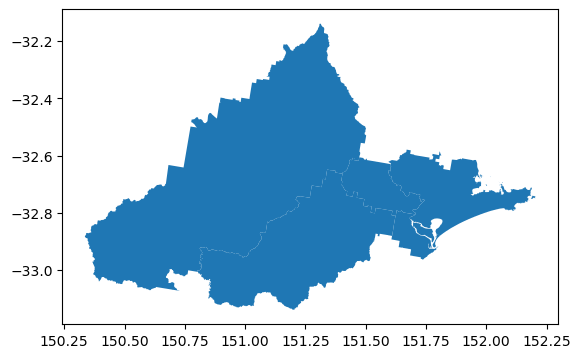

In [22]:
# Select the subset of LGAs to map
lga_list = ['Newcastle', 'Port Stephens', 'Maitland', 'Singleton', 'Cessnock']
lga_selected_df = lga_gdf[lga_gdf["LGA_NAME22"].isin(lga_list)]
lga_selected_df.plot()

In [24]:
# Write the selected LGA shapes to local disk
folder_out = os.path.join(base_path, "flood-activations", emsr_code)
path_out = os.path.join(folder_out, "LGAs_To_Map.geojson")
os.makedirs(folder_out, exist_ok=True)
lga_selected_df.to_file(path_out, driver="GeoJSON", crs="EPSG:4326")
print("[INFO] Wrote file to:\n", path_out)

[INFO] Wrote file to:
 /Users/cpurcell/Documents/PROJECT_FLOODS/ML4Floods_DEVELOPMENT/ML4Floods_Enhanced/FloodMapper/flood-activations/EMSR586/LGAs_To_Map.geojson


Alternatively, we could choose some of the EMSR AoIs to map instead:

In [26]:
# Write selected EMSR AoI shapes to disk
path_out = os.path.join(folder_out, "EMSR_AoIs_To_Map.geojson")
aoi_selected = aoi_df[(aoi_df.index == 30) | (aoi_df.index == 35)]
aoi_selected.to_file(path_out, driver="GeoJSON")
print("[INFO] Wrote file to:\n", path_out)

[INFO] Wrote file to:
 /Users/cpurcell/Documents/PROJECT_FLOODS/ML4Floods_DEVELOPMENT/ML4Floods_Enhanced/FloodMapper/flood-activations/EMSR586/EMSR_AoIs_To_Map.geojson


In [27]:
# Check if the files appear on disk
!ls {folder_out}

EMSR_AoIs_To_Map.geojson       ems_products_downloaded_backup
LGAs_To_Map.geojson            patches_to_map.geojson
ems_products


In the next notebook, we will split these shapes into square processing patches for use with the FloodMapper system.